<div> <center><img src="https://storage.googleapis.com/open-ff-common/openFF_logo.png" width="100"/></div>
<h1><center>Proprietary notebook - Aug 2023</center></h1>

In [1]:
!git clone https://github.com/gwallison/intg_support.git &>/dev/null;
!pip install itables  &>/dev/null;
!pip install geopandas  &>/dev/null;

import urllib
urllib.request.urlretrieve('https://storage.googleapis.com/gwa-test/georef-united-states-of-america-county.geojson',
                            'counties.geojson')

In [2]:
%run intg_support/local_frack_steps.py

<IPython.core.display.Javascript object>

In [3]:
# get full set of data
import intg_support.geo_tools as gt
work_dir = ''
# work_dir = './tmp'
get_fulldf(work_dir=work_dir) # this downloads most recent from the web.
df = get_df(os.path.join(work_dir,'full_df.parquet'))
df = df[df.in_std_filtered]

# NOW HAS FILTER to remove disclosures without chemicals!!
df = df[df.ingKeyPresent]

# uncomment following line to limit the dates
df = df[(df.date.dt.year>2013)&(df.date.dt.year<2023)]


In [4]:
# make a proprietary only data set
prop_df = df[df.bgCAS=='proprietary'].copy()

# remake tableau figures?

In [5]:
s = """30/70 Permian
aa-400 (aluminum oxide)
aluminum oxide
amorphous Silica
amorphous silica
amorphous silicia
ceramic microspheres
ceramic microspheres/glutaraldehyde
ceramic propant
ceramic proppant
ceramic proppant proprietary
copolymer resin fracturing proppant
corundum
crys4808-60-7talline sio2
crystalline cristobalite
crystalline silica
crystalline silica (quartz)
crystalline silica (quartz), proprietary
crystalline silica, quartz
crystalline silica: cristobalite
crystalline silica: quartz (sio2)
crystalline silica(quartz),proprietary
crystalline sio2
fumed silica
hydrophobic silica
hydrated magnesium silicate
magnesium silicate hydrate (talc)
meghemite
non- crystalline silica (impurity)
non-crystalline silica 
proppant
proprietary quartz
proprietary silica 
quartz
quartz (sio2)
sand
silica substrate
silica substitute with bonded coatings
silicate minerals - ts
zinc oxide"""
propp_lst = s.split('\n')

prop_df['is_proppant'] = prop_df.IngredientName.isin(propp_lst)
print(f'Total number of identified proprietary proppant records: {prop_df.is_proppant.sum()}')
prop_df[prop_df.is_proppant].IngredientName.value_counts()

Total number of identified proprietary proppant records: 1682


silica substrate                            532
silicate minerals - ts                      474
ceramic proppant                            220
hydrated magnesium silicate                  81
amorphous silica                             59
proprietary quartz                           58
fumed silica                                 55
crystalline sio2                             40
sand                                         31
corundum                                     28
crystalline silica (quartz)                  16
aa-400 (aluminum oxide)                      12
crystalline silica: quartz (sio2)            10
crystalline cristobalite                      8
proppant                                      7
ceramic microspheres                          7
copolymer resin fracturing proppant           6
silica substitute with bonded coatings        6
aluminum oxide                                5
non- crystalline silica (impurity)            3
quartz                                        3
hydrophobic silica                            3
magnesium silicate hydrate (talc)             3
zinc oxide                                    2
crystalline silica, quartz                    2
crystalline silica (quartz), proprietary      2
crystalline silica(quartz),proprietary        1
ceramic microspheres/glutaraldehyde           1
ceramic proppant proprietary                  1
crys4808-60-7talline sio2                     1
quartz (sio2)                                 1
ceramic propant                               1
meghemite                                     1
crystalline silica                            1
amorphous silicia                             1
Name: IngredientName, dtype: int64

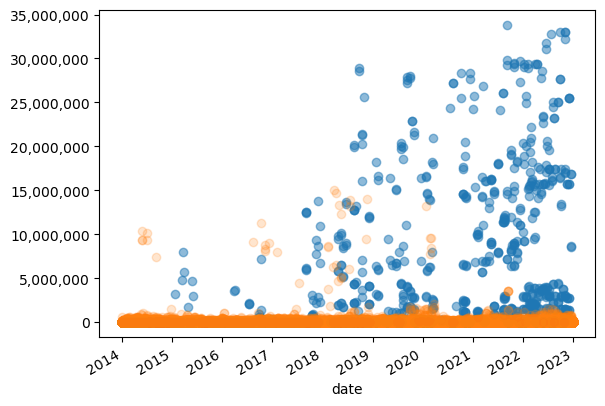

In [6]:
from pylab import gca, mpl
prop_df = prop_df[prop_df.calcMass < 100000000]
ax = prop_df[prop_df.is_proppant].plot('date','calcMass',style='o',alpha=.5,legend=False)
# prop_df[~prop_df.is_proppant].plot('date','calcMass', style='o',alpha=.2, ax=ax, legend=False)
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


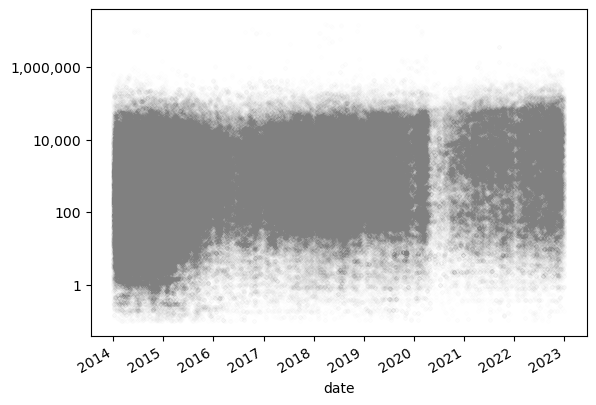

In [7]:
from pylab import gca, mpl
prop_df = prop_df[prop_df.calcMass> 0.1]  # don't show the teeny ones!
ax = prop_df[~prop_df.is_proppant].plot('date','calcMass', style='.', alpha=.005, logy=True,ax=ax, legend=False,color='grey')
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


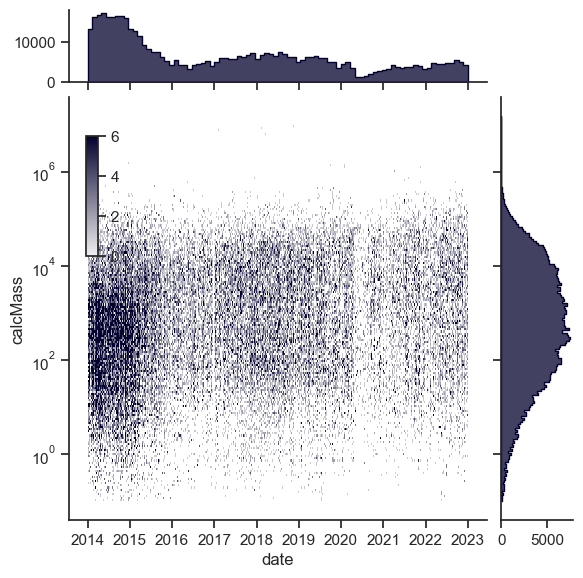

In [8]:
import seaborn as sns
sns.set_theme(style="ticks")

# Load the planets dataset and initialize the figure
g = sns.JointGrid(data=prop_df[~prop_df.is_proppant], x="date", y="calcMass", marginal_ticks=True)

# Set a log scaling on the y axis
g.ax_joint.set(yscale="log")

# # Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")



# show all the Purpose fields
You could also look at the [Browser's version](https://storage.googleapis.com/open-ff-browser/proprietary/analysis_proprietary.html#raw) of this.  Extra long purposes (using indicating multiple products) are truncated and combined.  They are not very useful...

In [9]:
prop_df.groupby('Purpose',as_index=False).size()

Purpose  size
0                                   (Other Ingredients)    22
1                                   *3rd Party Additive    97
2                            *3rd Party Scale Inhibitor    17
3                                                     0   266
4                                                     1    26
...                                                 ...   ...
1448  ropping Agent, Iron Control, Scale Inhibitor, ...     7
1449                                    scale inhibitor    20
1450        scale inhibitor & nitrate reducing bacteria    22
1451                                          scavenger    36
1452                                         surfactant     1

[1453 rows x 2 columns]

# make graphs of operators and suppliers

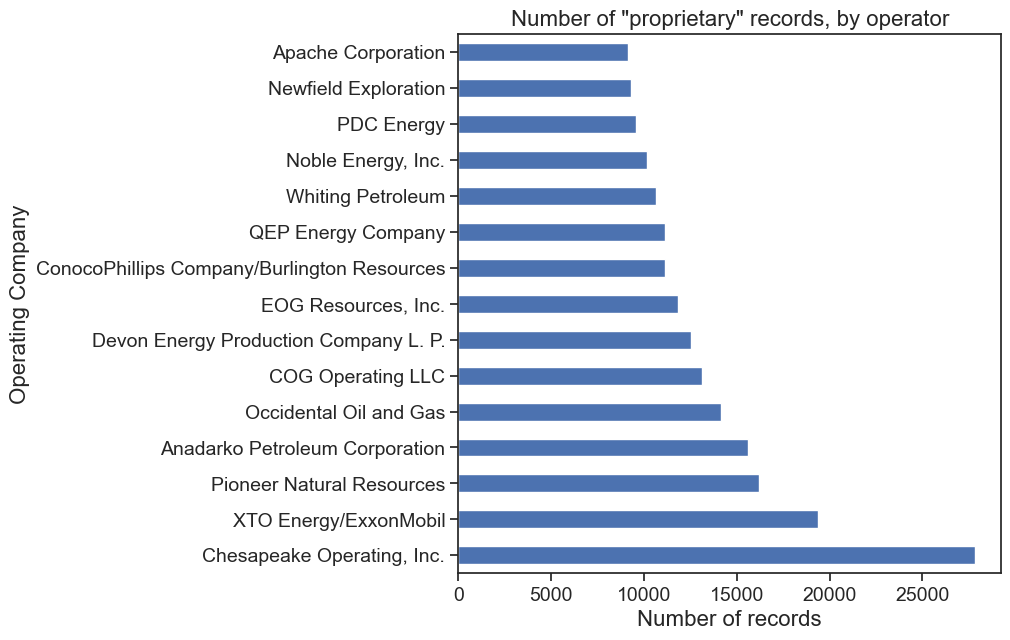

In [26]:
import matplotlib.pyplot as plt

# cas = prop_df.bgCAS.iloc[0]
# use the most common name given in FF for the label
gb1 = prop_df.groupby('bgOperatorName')['OperatorName'].agg(lambda x: x.value_counts().index[0])
gb1 = gb1.reset_index()
gb1.columns = ['bgOperatorName','op_common']
mg = pd.merge(prop_df,gb1,on='bgOperatorName',how='left')
newmg = mg.groupby('op_common')['UploadKey'].count().sort_values(ascending=False)
ax = newmg[:15].plot.barh(figsize=(7,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel('Operating Company',fontsize=16);
plt.title(f'Number of "proprietary" records, by operator',fontsize=16);

In [28]:
gb_full = df.groupby(['bgOperatorName','UploadKey'],as_index=False).size()
gb_full = gb_full.groupby('bgOperatorName')['UploadKey'].count().reset_index()
gb_full.columns = ['bgOperatorName','disclosure_cnt_all']

gb_prop = prop_df.groupby(['bgOperatorName','UploadKey'],as_index=False).size()
gb_prop = gb_prop.groupby('bgOperatorName')['UploadKey'].count().reset_index()
gb_prop.columns = ['bgOperatorName','disclosure_cnt_prop']

# gb_precs = prop_df.groupby

In [32]:
mg = pd.merge(gb_full,gb_prop,on='bgOperatorName',how='left')
mg = pd.merge(mg,gb1,on='bgOperatorName',how='left')
mg = pd.merge(mg,newmg.reset_index(),on='op_common',how='left')
mg = mg.rename({'UploadKey':'num_prop_records'},axis=1)
mg = mg[mg.disclosure_cnt_prop>0]
mg.disclosure_cnt_prop.fillna(0,inplace=True)
mg['prop_perc'] = mg.disclosure_cnt_prop/mg.disclosure_cnt_all * 100
mg.sort_values('disclosure_cnt_all',ascending=False)

bgOperatorName  disclosure_cnt_all  disclosure_cnt_prop  \
442                   eog                5960               5246.0   
1385                  xto                4719               3812.0   
43     anadarko petroleum                3951               3262.0   
260            chesapeake                3660               3001.0   
934               pioneer                3403               2216.0   
...                   ...                 ...                  ...   
888       pay dirt energy                   1                  1.0   
814      naifco oil & gas                   1                  1.0   
603     huntington energy                   1                  1.0   
595            hmd oil co                   1                  1.0   
778   midenergy operating                   1                  1.0   

                           op_common  num_prop_records   prop_perc  
442              EOG Resources, Inc.           11801.0   88.020134  
1385           XTO Energy/ExxonMobil           19357.0   80.779826  
43    Anadarko Petroleum Corporation           15605.0   82.561377  
260       Chesapeake Operating, Inc.           27836.0   81.994536  
934        Pioneer Natural Resources           16168.0   65.119013  
...                              ...               ...         ...  
888             Pay Dirt Energy, LLC               2.0  100.000000  
814            Naifco Oil & Gas, LLC               1.0  100.000000  
603        Huntington Energy, L.L.C.               1.0  100.000000  
595                  HMD OIL CO, INC               1.0  100.000000  
778         Midenergy Operating, LLC               2.0  100.000000  

[1121 rows x 6 columns]

# Suppliers

Here we need to remove records that are systems approach

In [13]:
c = df.CASNumber.str.lower().str.contains('listed below')
c1 = df.IngredientName.str.lower().str.contains('listed below')
print(f'Number of disclosures that are systems approach removed from consideration : {df[c1|c].UploadKey.unique().size}')
upk = df[c1|c].UploadKey.unique().tolist()
prop_df_sup = prop_df[~prop_df.UploadKey.isin(upk)]
print(f'Number of disclosures in the supplier analysis: {prop_df_sup.UploadKey.unique().size}')

Number of disclosures that are systems approach removed from consideration : 42736
Number of disclosures in the supplier analysis: 65309


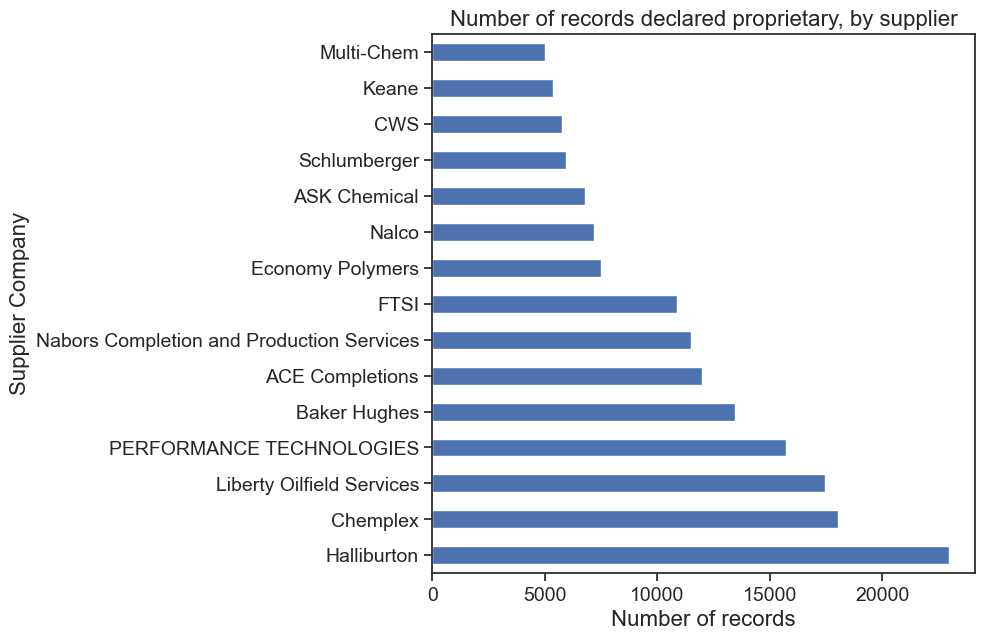

In [14]:
# records to exclude
not_comp = ['MISSING','Listed Above']

gb1 = prop_df_sup.groupby('bgSupplier')['Supplier'].agg(lambda x: x.value_counts().index[0])
gb1 = gb1.reset_index()
gb1.columns = ['bgSupplier','sup_common']
mg = pd.merge(prop_df_sup,gb1,on='bgSupplier',how='left')

mg = mg[~mg.sup_common.isin(not_comp)]

ax = mg.groupby('sup_common')['UploadKey'].count()\
         .sort_values(ascending=False)[:15].plot.barh(figsize=(7,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel('Supplier Company',fontsize=16);
plt.title(f'Number of records declared proprietary, by supplier',fontsize=16);

In [15]:
gb_full = df.groupby(['bgSupplier'],as_index=False).size()
gb_full.columns = ['bgSupplier','record_cnt_all']

gb_prop = prop_df_sup.groupby(['bgSupplier'],as_index=False).size()
gb_prop.columns = ['bgSupplier','record_cnt_prop']

# gb_precs = prop_df.groupby

In [16]:
mg = pd.merge(gb_full,gb_prop,on='bgSupplier',how='left')
mg = pd.merge(mg,gb1,on='bgSupplier',how='left')
mg.record_cnt_prop.fillna(0,inplace=True)
mg['prop_perc'] = mg.record_cnt_prop/mg.record_cnt_all * 100
mg.sort_values('record_cnt_all',ascending=False)

bgSupplier  record_cnt_all  record_cnt_prop    sup_common  \
814           missing         1590762         108859.0       MISSING   
587       halliburton          376651          22961.0   Halliburton   
1150     schlumberger          219086           5944.0  Schlumberger   
263          chemplex          190950          18051.0      Chemplex   
887     not a company          138803           2113.0  Listed Above   
...               ...             ...              ...           ...   
971   petro harvester               1              0.0           NaN   
960               pep               1              0.0           NaN   
954             pearl               1              0.0           NaN   
953    peak operating               1              0.0           NaN   
0          24-7 sands               1              0.0           NaN   

      prop_perc  
814    6.843198  
587    6.096094  
1150   2.713090  
263    9.453260  
887    1.522301  
...         ...  
971    0.000000  
960    0.000000  
954    0.000000  
953    0.000000  
0      0.000000  

[1465 rows x 5 columns]

# MAPS

In [17]:
import geopandas as gpd
import folium
import numpy as np

def fix_county_names(df):
    trans = {'mckenzie':'mc kenzie',
             'dewitt':'de witt',
             'mcclain':'mc clain',
             'mcintosh':'mc intosh',
             'mckean':'mc kean',
             'mcmullen':'mc mullen'}
    for wrong in trans.keys():
        df.CountyName = np.where(df.CountyName==wrong,trans[wrong],df.CountyName)
    return df

def create_county_choropleth(data,
                             start_loc=[40, -96],start_zoom = 6,
                             custom_scale = [], plotlog = True,
                             legend_name = 'Test legend',
                             show_only_data_states=True,
                             #popup_enabled=True, tooltip_enabled=False,
                             fields = ['CountyName','orig_value'],
                             aliases = ['County: ','data: ']):
    fn = r"counties.geojson"
    if len(data)<1:
        print('No mappable data')
        return
    geojson = gpd.read_file(fn)
    data['orig_value'] = data.value

    geojson['StateName'] = geojson.ste_name.str.lower()
    geojson['CountyName'] = geojson.coty_name.str.lower()
    geojson = fix_county_names(geojson)
    working = geojson[['StateName','CountyName','coty_code','geometry']]
    #geojson = geojson.to_crs(5070)
    working = pd.merge(working,data,on=['StateName','CountyName'],how='left')
    #print(geojson.info())
    if start_loc==[]:
        start_loc = [geojson.geometry.centroid.x.mean(),geojson.geometry.centroid.y.mean()]
    f = folium.Figure(width=600, height=400)
    m = folium.Map(location= start_loc, tiles="openstreetmap",
                   zoom_start=start_zoom).add_to(f)
    if plotlog:
        working.value = np.log10(working.value+1)
        legend_name = legend_name + ' (log transformed)'
    working.orig_value.fillna('no data',inplace=True)
    
    if custom_scale==[]:
        custom_scale = (working['value'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
    if show_only_data_states:
        gb = data.groupby(['StateName','CountyName'],as_index=False)['value'].first()
        datalst = []
        for i,row in gb.iterrows():
            datalst.append((row.StateName,row.CountyName))
        wlst = []
        working['tup'] = list(zip(working.StateName.tolist(),working.CountyName.tolist()))
        geojson['tup'] = list(zip(geojson.StateName.tolist(),geojson.CountyName.tolist()))
        
#         working = working[working.StateName.isin(data.StateName.unique().tolist())]
#         geojson = geojson[geojson.StateName.isin(data.StateName.unique().tolist())]
#         c1 = working.CountyName.isin(data.CountyName.unique().tolist())
#         c2 = working.StateName.isin(data.StateName.unique().tolist())
#         c3 = geojson.CountyName.isin(data.CountyName.unique().tolist())
#         c4 = geojson.StateName.isin(data.StateName.unique().tolist())
        working = working[working.tup.isin(datalst)]
        geojson = geojson[geojson.tup.isin(datalst)]
    working.StateName = working.StateName.str.title()
    working.CountyName = working.CountyName.str.title()
    #print(f'States in geojson: {working.StateName.unique().tolist()}')
    folium.Choropleth(
                geo_data=geojson,
                data=working,
                columns=['coty_code', 'value'],  #Here we tell folium to get the fips and plot values for each state
                key_on='feature.properties.coty_code',
                threshold_scale=custom_scale, #use the custom scale we created for legend
                #fill_color='YlOrRd',
                fill_color='RdGy_r',
                nan_fill_color="gainsboro", #Use white color if there is no data available for the area
                fill_opacity=0.7,
                line_opacity=0.4,
                line_weight=0.4,
                legend_name= legend_name, #title of the legend
                highlight=True,
                line_color='black').add_to(m) 
    
    folium.features.GeoJson(
                data=working,
                name='',
                smooth_factor=2,
                style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                popup=folium.features.GeoJsonPopup(
                    fields=fields,
                    aliases=aliases, 
                    localize=True,
                    sticky=False,
                    labels=True,
                    style="""
                        background-color: #F0EFEF;
                        border: 2px solid black;
                        border-radius: 3px;
                        box-shadow: 3px;
                    """,
                    max_width=800,),
                        highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                    ).add_to(m)  

    

# fit_bounds needs work: https://stackoverflow.com/questions/58162200/pre-determine-optimal-level-of-zoom-in-folium
#     sw = data[['bgLatitude', 'bgLongitude']].min().values.tolist()
#     ne = data[['bgLatitude', 'bgLongitude']].max().values.tolist()

#     m.fit_bounds([sw, ne]) 
    display(f)


def CountyMap(df):
    state_list = df.bgStateName.unique().tolist()
    #start_loc = get_geog_center(state_list)
    #print(statename,start_loc)
    cond = (df.loc_within_state=='YES')&(df.loc_within_county=='YES')
    if cond.sum()==0:  # no valid fracks for this state
        display(md('## No mappable fracks for this operator!'))
        # display(md(f'Any data in this state set may be labeled incorrectly as {statename}'))
        return
    gb = df[cond].groupby(['bgStateName','bgCountyName',
                                                   'UploadKey'],as_index=False)['bgCAS'].count()
    gb = gb.groupby(['bgStateName','bgCountyName'],as_index=False)['UploadKey'].count().rename({'bgStateName':'StateName',
                                                                                                'bgCountyName':'CountyName',
                                                                                                'UploadKey':'value'},
                                                                                                axis=1)
    #zoom = get_zoom_level(df[['bgLatitude','bgLongitude']])
    # if statename in ['texas','california']:
    #     zoom = 5
    # if statename in ['alaska']:
    #     zoom = 4
    # Look here for different way to scale appropriately:
    # https://stackoverflow.com/questions/58162200/pre-determine-optimal-level-of-zoom-in-folium
    
    zoom = 3.6
    create_county_choropleth(gb,plotlog=True,#plotlog=True,#custom_scale= [0,1,2,3,4],
                             #start_loc=start_loc, # center of state's data
                             legend_name='Number of FracFocus disclosures',
                             start_zoom=zoom,fields=['StateName','CountyName','orig_value'],
                             aliases=['State: ','County: ','Number Fracking disclosures: '])

    
CountyMap(prop_df)


# make map with proprietary fraction

bgStateName bgCountyName  APINumber  APINumber_prop   perc_prop
0       alabama         bibb          4             4.0  100.000000
1       alabama      conecuh          5             5.0  100.000000
2       alabama     escambia          1             0.0    0.000000
3       alabama    jefferson          2             2.0  100.000000
4       alabama       mobile          1             0.0    0.000000
..          ...          ...        ...             ...         ...
533     wyoming     sublette       1345          1121.0   83.345725
534     wyoming   sweetwater        318           165.0   51.886792
535     wyoming        uinta          2             2.0  100.000000
536     wyoming     washakie          2             1.0   50.000000
537     wyoming       weston          2             1.0   50.000000

[538 rows x 5 columns]

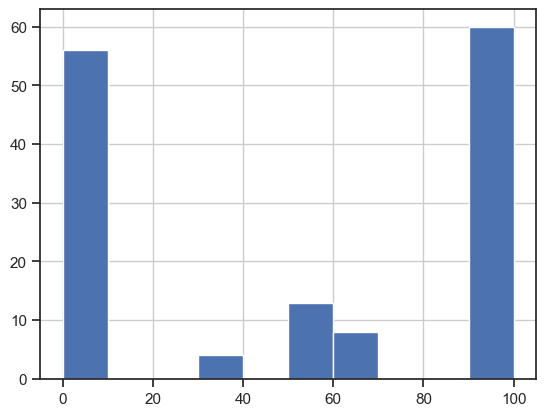

In [18]:
# first make data frame with number of fracks by county
gb_all = df.groupby(['bgStateName','bgCountyName','APINumber'],as_index=False).size()
gb_all = gb_all.groupby(['bgStateName','bgCountyName'],as_index=False)['APINumber'].count()                    
# gb_all

# now make data frame with number of fracks with at least one prop. chem by county
gb_prop = prop_df.groupby(['bgStateName','bgCountyName','APINumber'],as_index=False).size()
gb_prop = gb_prop.groupby(['bgStateName','bgCountyName'],as_index=False)['APINumber'].count()                    
gb_prop.columns = ['bgStateName','bgCountyName','APINumber_prop']
gb_prop

mg = pd.merge(gb_all,gb_prop,on=['bgStateName','bgCountyName'],how='left')
mg.APINumber_prop.fillna(0,inplace=True)
mg['perc_prop'] = mg.APINumber_prop/mg.APINumber *100
mg[mg.APINumber<4].perc_prop.hist()

mg

In [19]:
def CountyPropMap(df):
    state_list = df.bgStateName.unique().tolist()
    # cond = (df.loc_within_state=='YES')&(df.loc_within_county=='YES')
    # if cond.sum()==0:  # no valid fracks for this state
    #     display(md('## No mappable fracks for this operator!'))
    #     return
    zoom = 3.6
    df['value'] = df.perc_prop
    df['StateName'] = df.bgStateName
    df['CountyName'] = df.bgCountyName
    create_county_choropleth(df,plotlog=False,custom_scale= [0,10,20,30,40,50,60,70,80,90,100],
                             #start_loc=start_loc, # center of state's data
                             legend_name='Percent of disclosures with at least one proprietary record',
                             start_zoom=zoom,fields=['bgStateName','bgCountyName','orig_value','APINumber'],
                             aliases=['State: ','County: ','% disc with proprietary: ','total num of disclosures'])
    
CountyPropMap(mg[mg.APINumber>5].copy()) # county must have more than 5 FF wells


# Compare to Trickey 2020
state-wide proprietary rates

In [20]:
gb_all = df.groupby(['bgStateName','UploadKey'],as_index=False).size()
gb_all = gb_all.groupby('bgStateName',as_index=False)['UploadKey'].count()
gb_all.columns = ['bgStateName','num_all_disc']

gb_prop = df[df.bgCAS=='proprietary'].groupby(['bgStateName','UploadKey'],as_index=False).size()
gb_prop = gb_prop.groupby('bgStateName',as_index=False)['UploadKey'].count()
gb_prop.columns = ['bgStateName','num_prop_disc']

mg = pd.merge(gb_all,gb_prop,on='bgStateName',how='left')
mg.num_prop_disc.fillna(0,inplace=True)

mg['state_prop_percent'] = mg.num_prop_disc/mg.num_all_disc *100
mg.sort_values('num_all_disc',ascending=False)

bgStateName  num_all_disc  num_prop_disc  state_prop_percent
23           texas         63506        54732.0           86.183983
21        oklahoma         13188         9812.0           74.400971
4         colorado         11447        10143.0           88.608369
19    north dakota         10302         9193.0           89.235100
16      new mexico          8257         7360.0           89.136490
22    pennsylvania          6415         4674.0           72.860483
27         wyoming          3514         2749.0           78.229937
24            utah          2736         2514.0           91.885965
20            ohio          2625         2155.0           82.095238
10       louisiana          2600         2188.0           84.153846
26   west virginia          2450         1828.0           74.612245
3       california          2253            8.0            0.355082
2         arkansas           827          483.0           58.403869
25        virginia           469          330.0           70.362473
8           kansas           451          210.0           46.563193
13         montana           352          241.0           68.465909
1           alaska           176           87.0           49.431818
12     mississippi           134           83.0           61.940299
0          alabama            56           52.0           92.857143
9         kentucky            34           33.0           97.058824
11        michigan            11            8.0           72.727273
14        nebraska             8            4.0           50.000000
15          nevada             4            4.0          100.000000
17        new york             3            2.0           66.666667
7          indiana             2            0.0            0.000000
6         illinois             2            0.0            0.000000
18  north carolina             1            1.0          100.000000
5            idaho             1            0.0            0.000000

# ambiguousID

In [21]:
amb_df = df[df.bgCAS=='ambiguousID'].copy()
amb_df['has_mass'] = amb_df.calcMass>0
amb_df.has_mass.value_counts()

False    49564
True     30213
Name: has_mass, dtype: int64

## what are the ambiguousID `IngredientName`s


In [22]:
amb_df[amb_df.has_mass].IngredientName.value_counts()

no hazardous ingredients                           4064
water (including mix water supplied by client)*    3036
walnut hulls                                        856
enzyme                                              636
surfactants                                         629
                                                   ... 
antifoam                                              1
alkoxylated amine                                     1
alkylene oxide block polymer                          1
nfidb:15% fe acid                                     1
alkyl phoshonate                                      1
Name: IngredientName, Length: 690, dtype: int64

## what are the ambiguousID `IngredientName`s  (Just the big ones)
Mostly water-type things.  A handful of proppants

In [23]:
amb_df[amb_df.calcMass>100000].IngredientName.value_counts()

water (including mix water supplied by client)*         3031
silica substrate                                         336
carrier / base fluid - water                             248
no hazardous ingredients                                 172
water (including mix water supplied by client)           146
                                                        ... 
7647-01-0                                                  1
petroleum distillates, hydrotreated light                  1
no hazardous substances above cut-off values               1
contains no hazardous materials above cut-off values       1
3rd party clay control                                     1
Name: IngredientName, Length: 143, dtype: int64

# AmbiguousID Proppants: Number and mass

In [24]:
proppants = ['silica substrate',
 'remainder is made up of various other oxides and trace elements, of which cao, mgo, and fe2o3 are the largest percentages',
 'cyrstalline silica','mix of various oxides (cao, mgo, and fe2o4','resin coated fracturing proppant',
 '40/70 ppc','mix of various oxides (cao, mgo, and fe2o3',
 'mix of various oxides (cao, mgo, and fe203','mix of various oxides (cao, mgo, and fe204',
 'crystalline silica, quartz','100 mesh sand','ceramic',
 '20/40 pc','crystalline silica,quartz','aluminum oxide','nfidb:sand-200 mesh silica',
 'nfidb:200 mesh ssa-1','non-crystalline silica (impurity)',
 'silica in form of quartz','40/70 white','mulite']
c = amb_df.IngredientName.isin(proppants)

print(f'Number of ambiguousID proppants = {len(amb_df[c])}; calculated mass= {round(amb_df[c].calcMass.sum(),0):,} lbs.')

Number of ambiguousID proppants = 2545; calculated mass= 453,785,833.0 lbs.


## Likely water records in ambiguousID

In [25]:
c = amb_df.IngredientName.str.contains('water')

print(f'Number of ambiguousID **water** = {len(amb_df[c])}; calculated mass= {round(amb_df[c].calcMass.sum(),0):,} lbs.')

Number of ambiguousID **water** = 4428; calculated mass= 152,380,591,226.0 lbs.
